In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

patient = 5

# 0. Preprocessing and Reading Data

In [2]:
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [3]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [4]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

C:\Users\vedan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [5]:
# Regression Error
reg_window_size = 4
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        if np.isnan(times).any():
            errors = np.append(errors, -1)
            continue
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    while(len(values) < 2):
        values = np.append(values, 0)
        heights = np.append(heights, 0)
        times = np.append(times, 0)
        times2 = np.append(times2, 0)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

12.000000044703484
0.08333333302289248


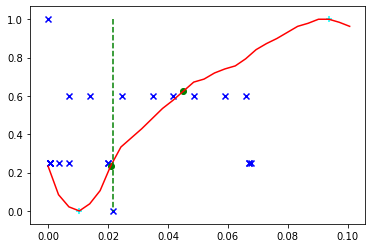

[0.62433862 0.23280423]
[0.04497355 0.13227514]
[0.04513889 0.02083333]


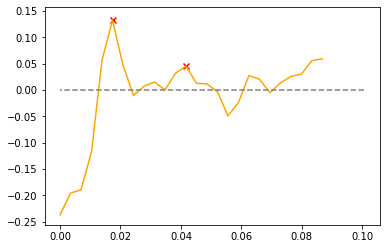

41.14285624513822
0.02430555608589202


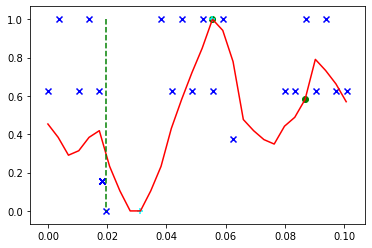

[0.58139535 1.        ]
[0.43217055 0.58139536]
[0.08680556 0.05555556]


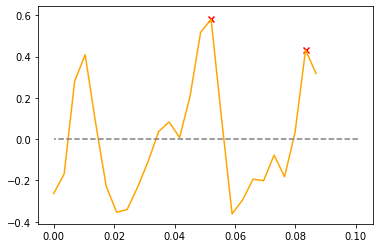

9.931034523581777
0.1006944440305233


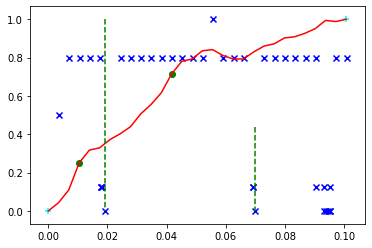

[0.71341463 0.25      ]
[0.10467479 0.14735772]
[0.04166667 0.01041667]


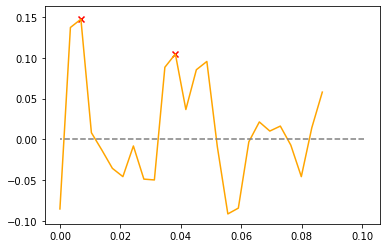

10.285714307609869
0.09722222201526165


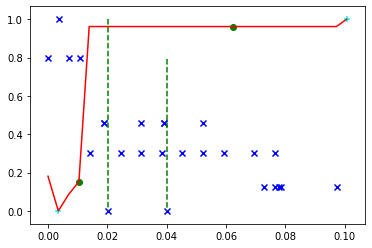

[0.96190476 0.15238095]
[3.33066907e-16 8.76190476e-01]
[0.0625     0.01041667]


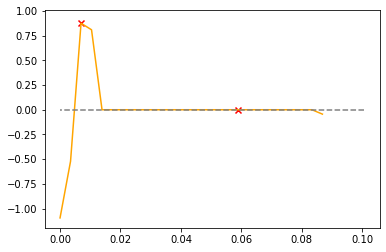

9.931034431729673
0.10069444496184587


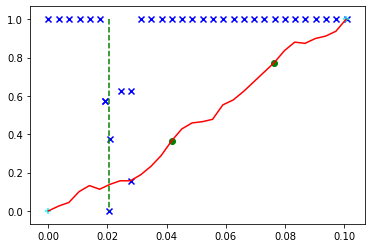

[0.77358491 0.36477987]
[0.08385745 0.1048218 ]
[0.07638889 0.04166667]


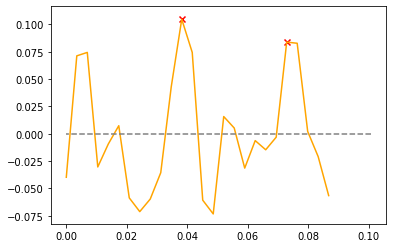

0.0
0.0


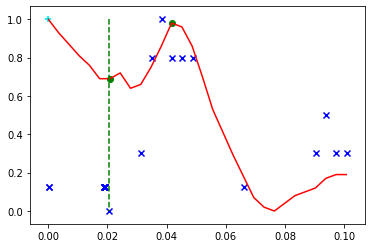

[0.69 0.98]
[0.07333333 0.37000004]
[0.02083333 0.04166667]


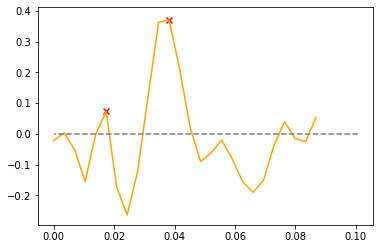

19.20000011444092
0.052083333022892475


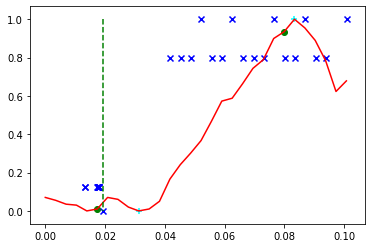

[0.01005025 0.93467337]
[0.12562815 0.21440538]
[0.01736111 0.07986111]


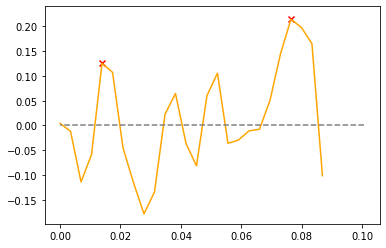

12.521739164913084
0.0798611108912155


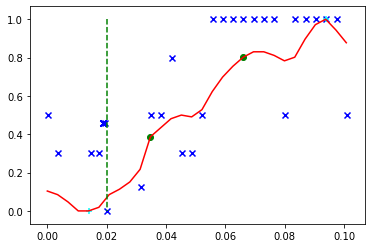

[0.80188679 0.38679245]
[0.09748428 0.15566037]
[0.06597222 0.03472222]


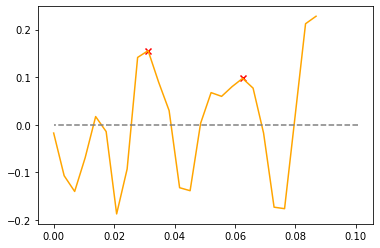

11.519999929618836
0.08680555608589202


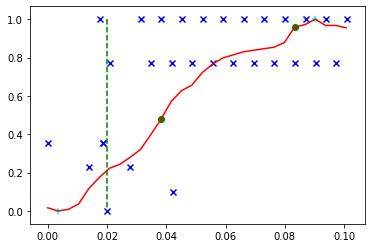

[0.47773279 0.95951417]
[0.09379216 0.10728745]
[0.03819444 0.08333333]


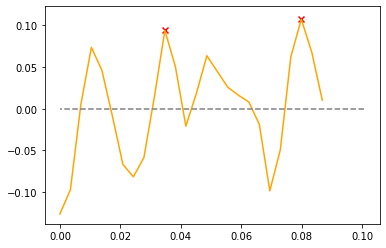

15.157894570411408
0.06597222294658422


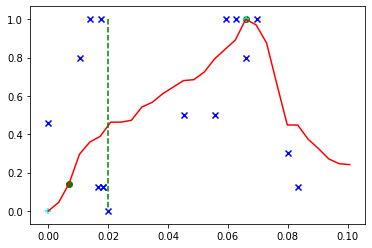

[0.14285714 1.        ]
[0.1633826  0.40968807]
[0.00694445 0.06597222]


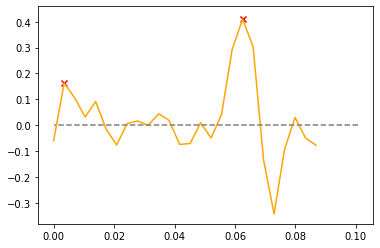

32.0
0.03125


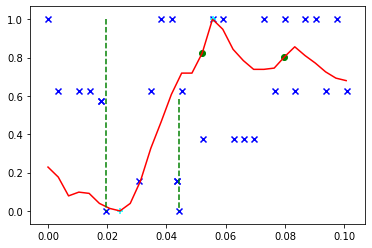

[0.80392157 0.82352941]
[0.1949891  0.44662312]
[0.07986111 0.05208333]


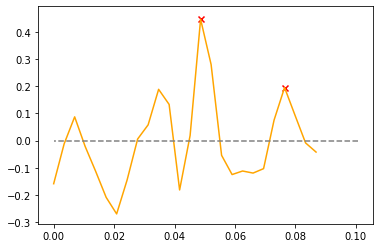

15.999999999999996
0.0625


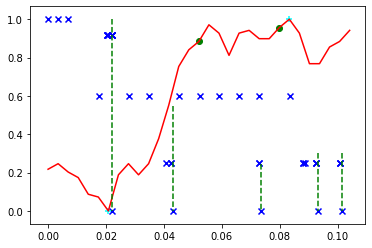

[0.88405797 0.95652174]
[0.30193239 0.34782612]
[0.05208333 0.07986111]


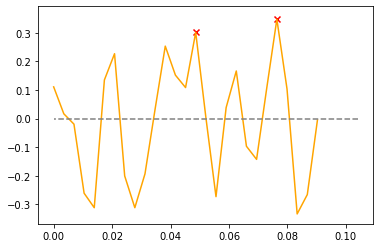

0.0
0.0


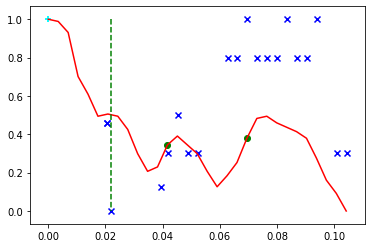

[0.34482759 0.37931034]
[0.25287358 0.2605364 ]
[0.04166667 0.06944444]


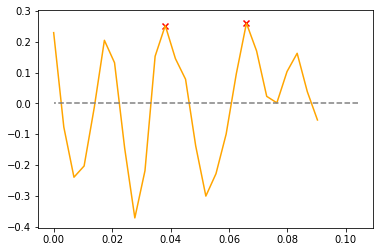

0.0
0.0


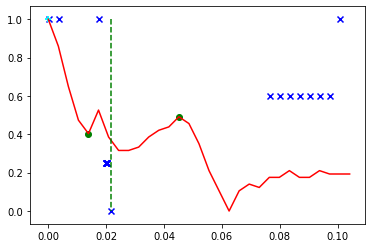

[0.40350877 0.49122807]
[0.25146197 0.26900582]
[0.01388889 0.04513889]


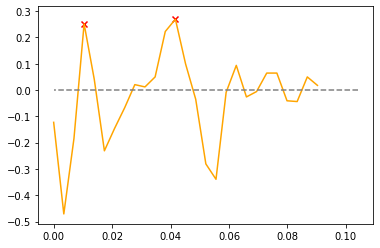

19.200000157356264
0.05208333290647715


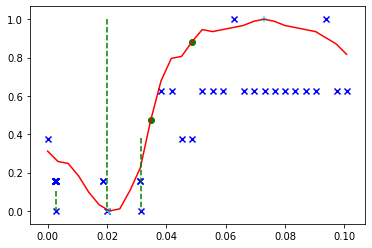

[0.88172043 0.47311828]
[0.13620072 0.34050179]
[0.04861111 0.03472222]


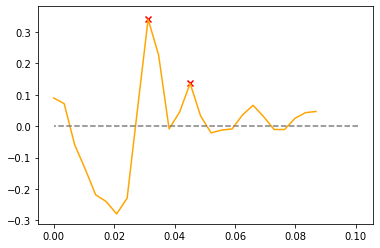

11.999999893829228
0.08333333407063037


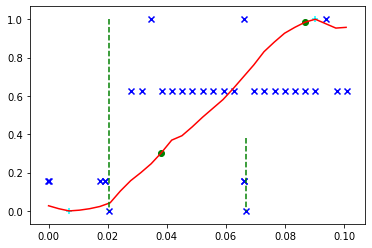

[0.30384615 0.98461538]
[0.05000001 0.08846155]
[0.03819444 0.08680556]


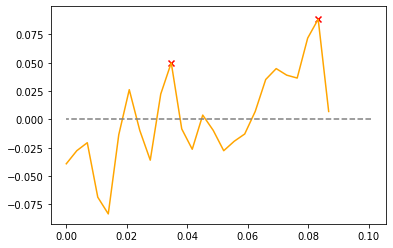

13.09090905322516
0.0763888891087845


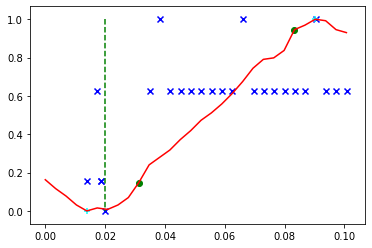

[0.14728682 0.94573643]
[0.09302325 0.11498708]
[0.03125    0.08333333]


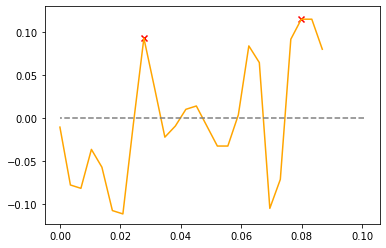

10.285714307609869
0.09722222201526165


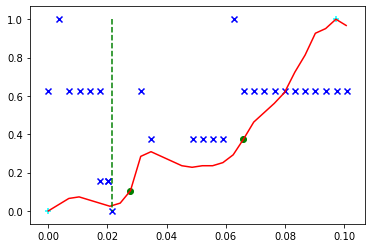

[0.37398374 0.10569106]
[0.07317072 0.25203252]
[0.06597222 0.02777778]


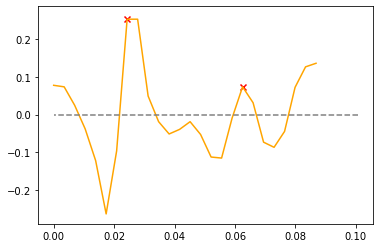

In [6]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [7]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

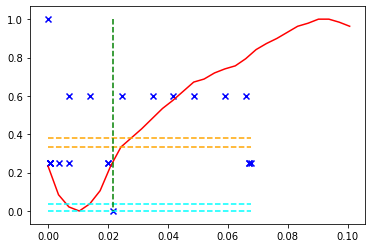

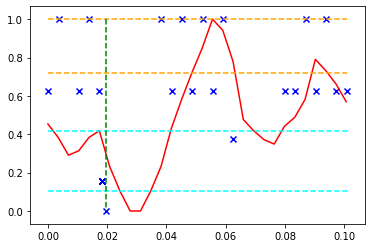

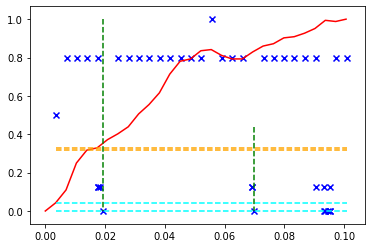

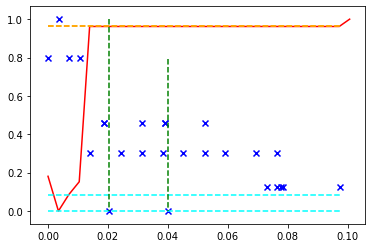

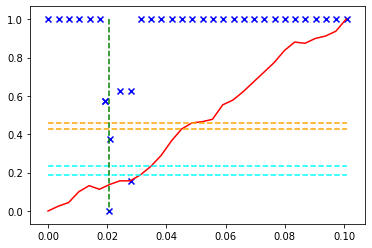

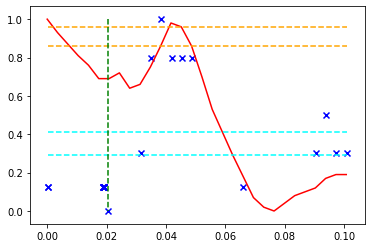

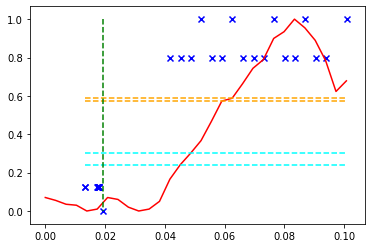

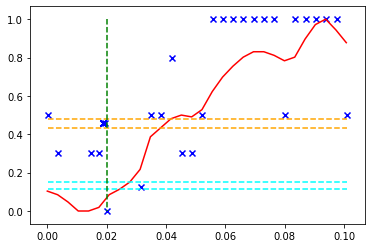

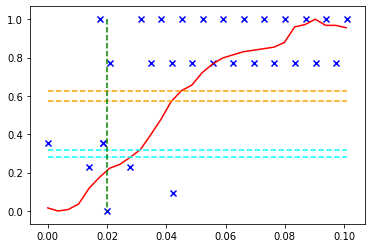

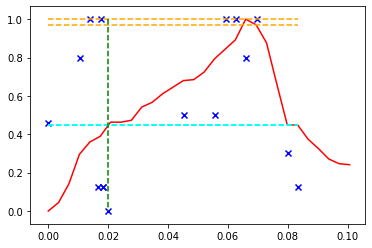

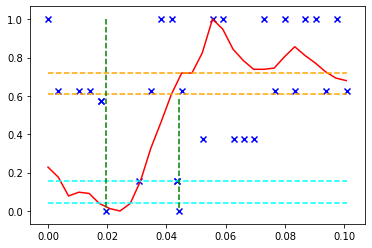

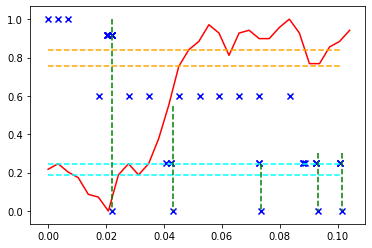

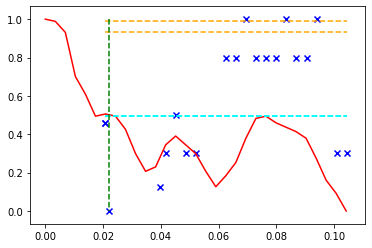

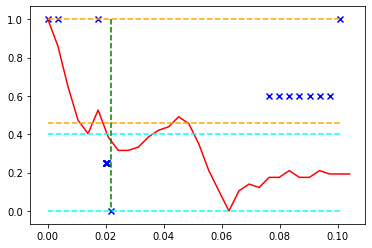

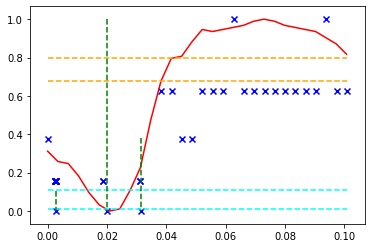

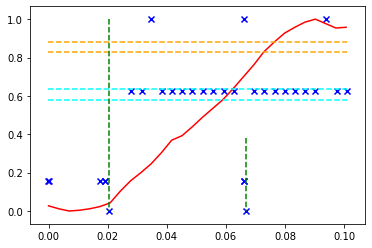

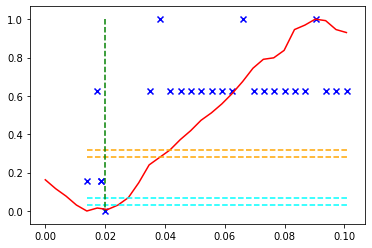

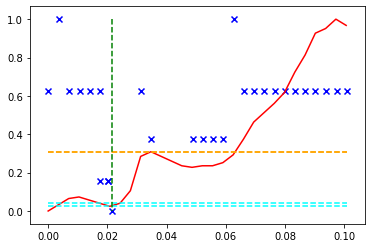

In [20]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    plt.plot([po1, po2], [window_mins[i][1], window_mins[i][1]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][1], window_maxs[i][1]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [9]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [10]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))
# print(maximum)

In [11]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

0.5955320399764844


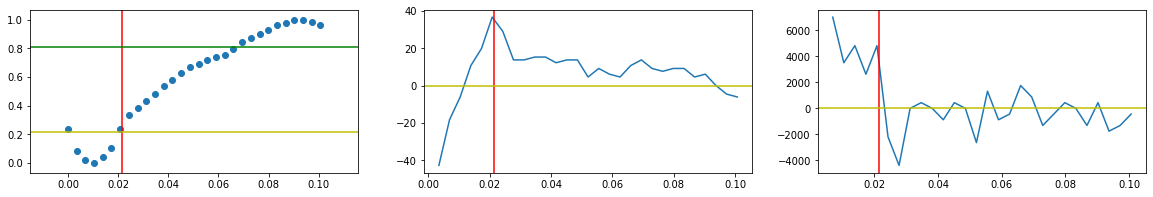

0.3006008679203295


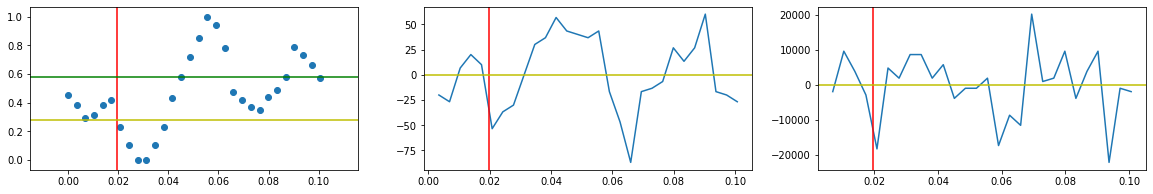

0.610248447204969


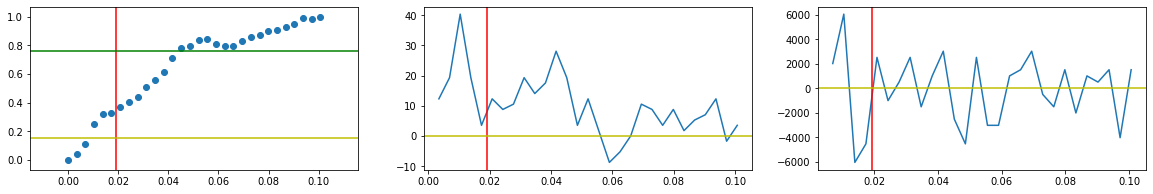

0.7015873015873015


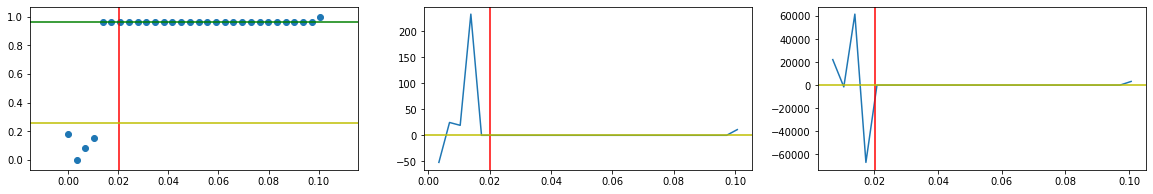

0.48951130903550916


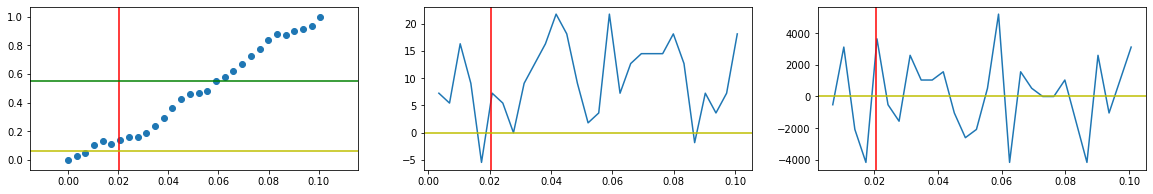

-0.4200000000000001


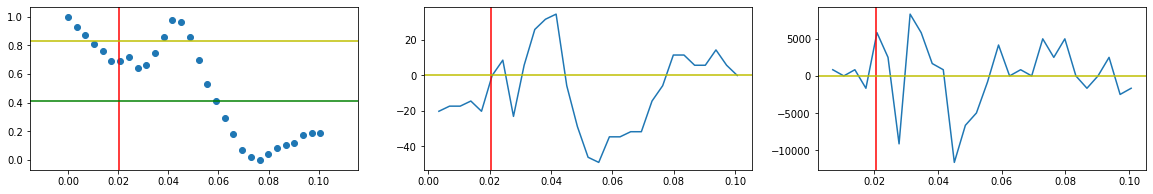

0.48225253250378874


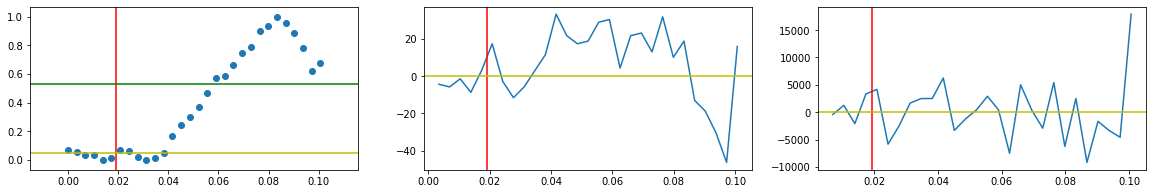

0.6299539586530649


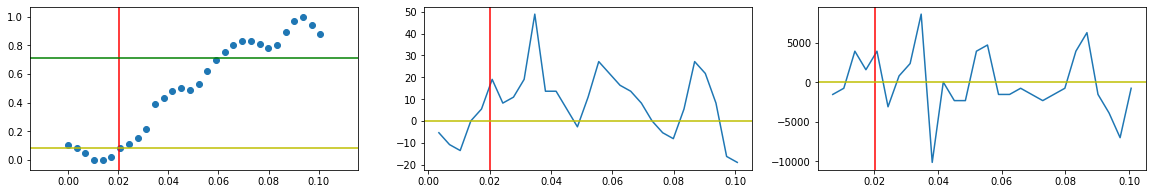

0.6180317658050452


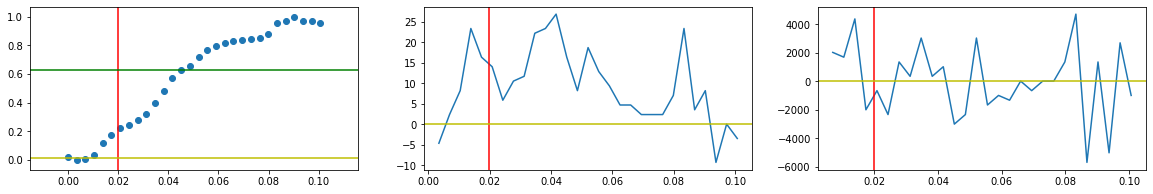

0.4591543513957307


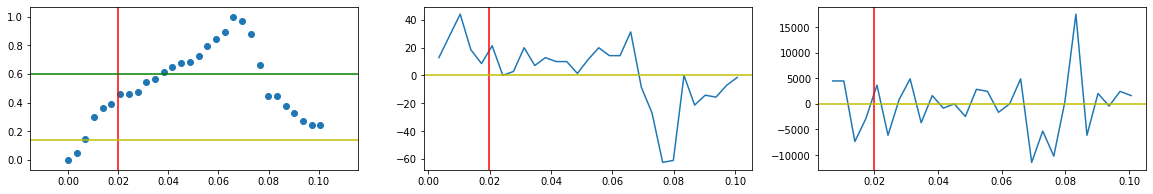

0.4162091503267974


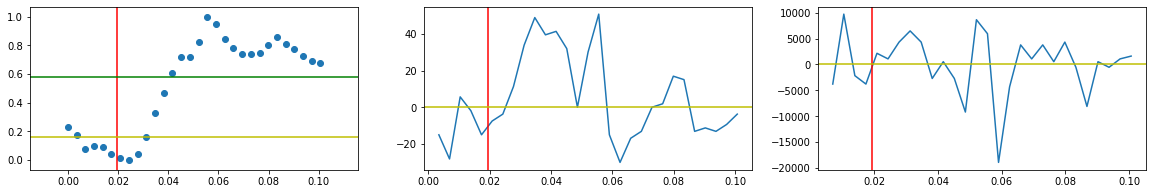

0.6204278812974465


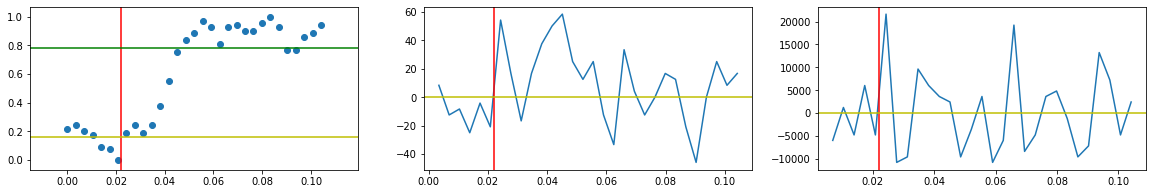

-0.5996829171621084


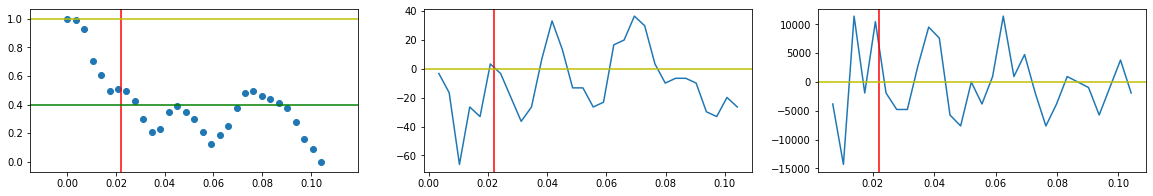

-0.306321358952938


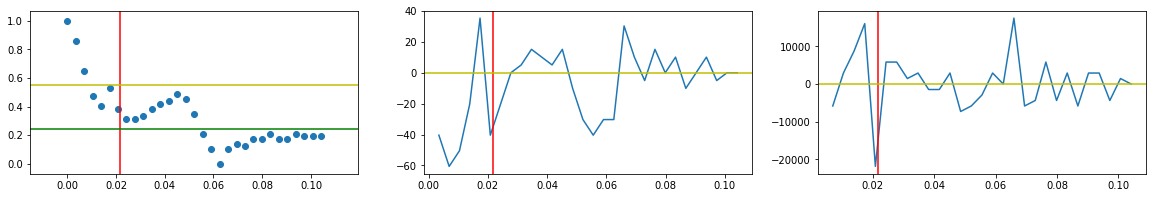

0.7296393476359521


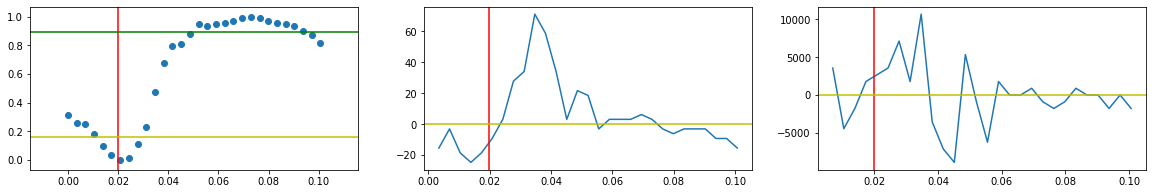

0.5031804733727812


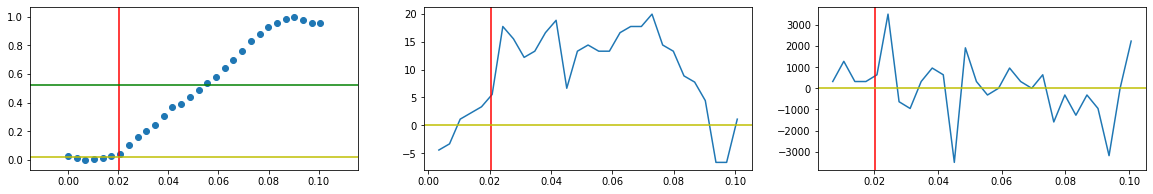

0.3290267011197243


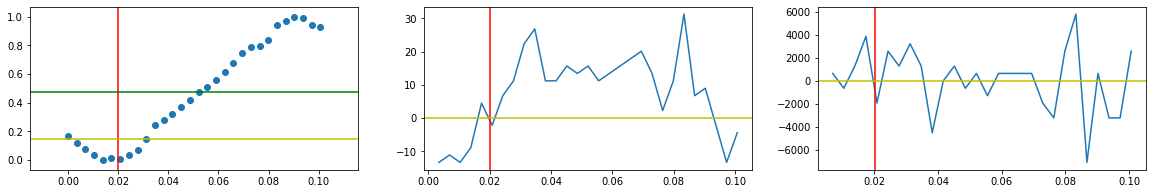

0.4046563192904657


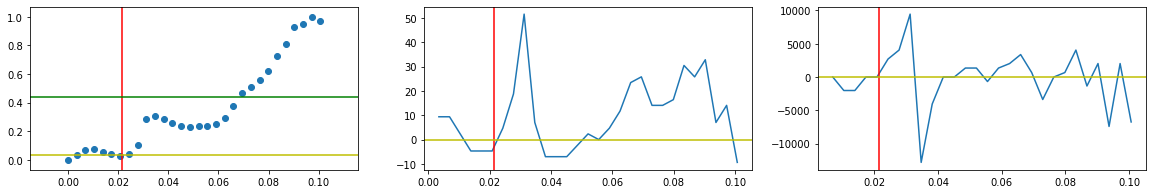

[0.5955320399764844, 0.3006008679203295, 0.610248447204969, 0.7015873015873015, 0.48951130903550916, -0.4200000000000001, 0.48225253250378874, 0.6299539586530649, 0.6180317658050452, 0.4591543513957307, 0.4162091503267974, 0.6204278812974465, -0.5996829171621084, -0.306321358952938, 0.7296393476359521, 0.5031804733727812, 0.3290267011197243, 0.4046563192904657]


In [12]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
#     cut = insulinTime_np[i,maximum[i]]
#     print(maximum[i])
#     print(cut)
#     cut1 = np.where(insulinTime_np[i]==cut)
#     print(int(cut1[0]))
#     print(cut1)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-maximum[i]:-1])
    mean2 = np.nanmean(cgmNorm_np[i][-maximum[i]:0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(cgmSeries_np[i],sl)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(cgmSeries_np[i],sl_1)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(mean_dif)

# 1.d Ananth Features

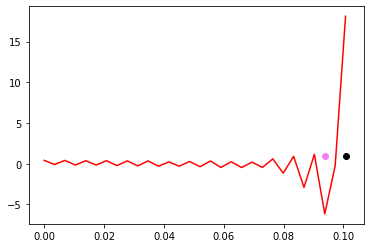

[18.11111111111111, -6.16890692998847, 0.33540114403354626, 12.169671348089839]


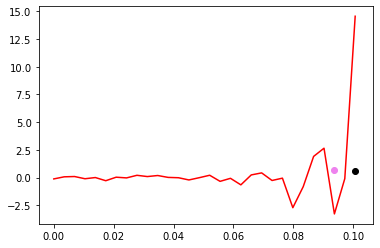

[14.558139534883722, -3.273537407408803, 0.37575346877225313, 7.68308225940291]


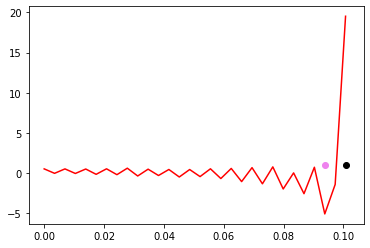

[19.530487804878057, -5.104806618008133, 0.3325855176418455, 13.713063736305374]


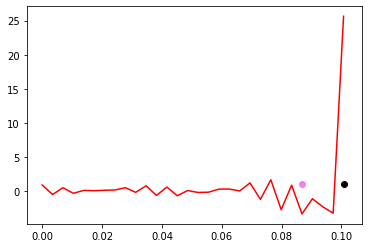

[25.647619047619052, -3.3778900813541424, 0.5177819236759869, 22.45537199874489]


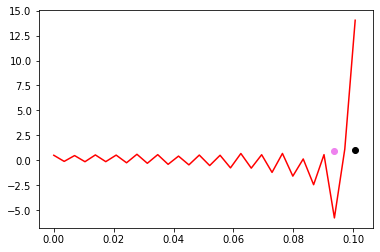

[14.037735849056602, -5.767966079785664, 0.24850618834344154, 7.925586947208143]


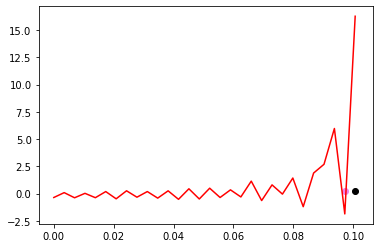

[16.27, -1.8716895037451442, 0.7913478807705434, 9.787981434825776]


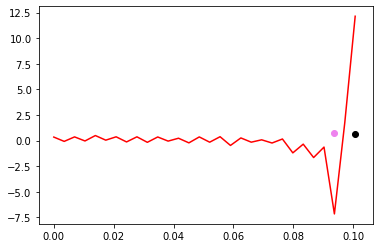

[12.14572864321608, -7.171432767850301, 0.1537011809179219, 6.702810030190219]


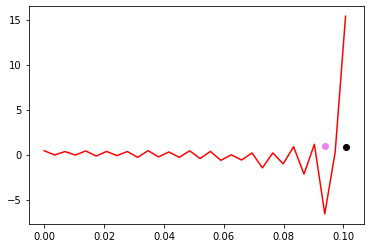

[15.367924528301884, -6.598128674542633, 0.22380729942451363, 9.383174914504526]


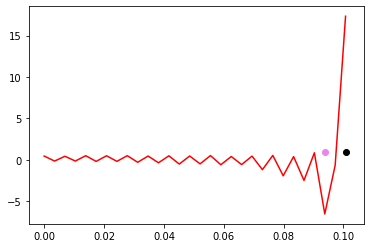

[17.327935222672064, -6.537839455464832, 0.24782541719906673, 11.547723255211343]


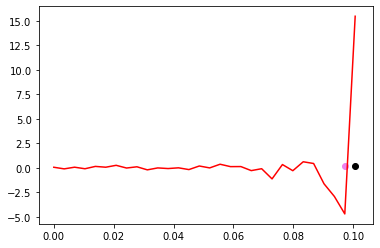

[15.472906403940886, -4.689835333344853, 0.22485955808683578, 8.82215076384484]


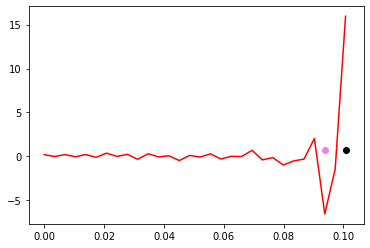

[15.947712418300656, -6.549171773991666, 0.2841979511959984, 9.801875227881418]


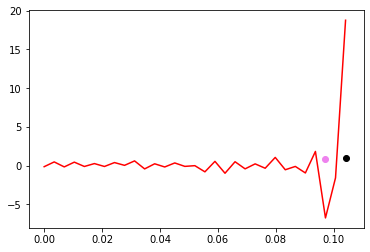

[18.753623188405797, -6.7478392393310305, 0.3874941943848158, 13.055274054414578]


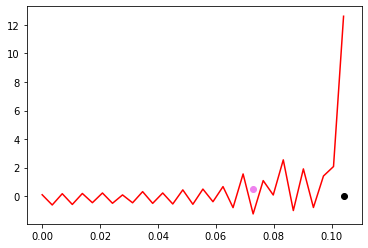

[12.60919540229885, -1.2433090079052955, 0.5725150666289932, 5.6877269054910125]


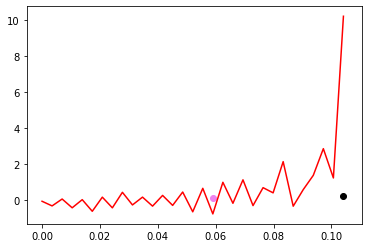

[10.192982456140347, -0.7789003880157936, 0.5944574644478848, 3.722345856376937]


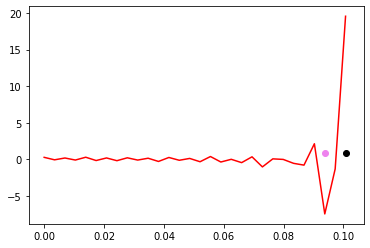

[19.5483870967742, -7.441636327770571, 0.356808422046806, 14.292672905801457]


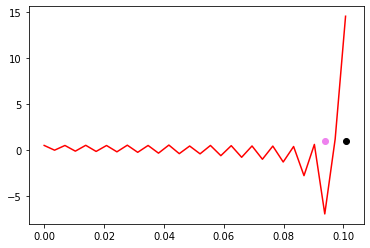

[14.530769230769232, -6.983298806963561, 0.20418649228955332, 8.887601634717324]


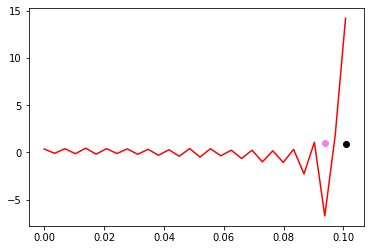

[14.23255813953488, -6.724991403204041, 0.2455242377099066, 8.393674361080876]


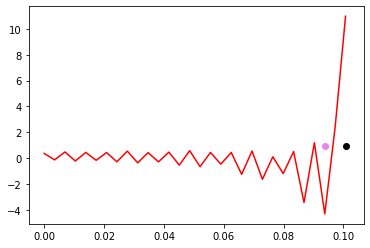

[10.967479674796744, -4.296657340555494, 0.18398650751697493, 5.366051736699405]


[[18.11111111111111,
  -6.16890692998847,
  0.33540114403354626,
  12.169671348089839],
 [14.558139534883722,
  -3.273537407408803,
  0.37575346877225313,
  7.68308225940291],
 [19.530487804878057,
  -5.104806618008133,
  0.3325855176418455,
  13.713063736305374],
 [25.647619047619052,
  -3.3778900813541424,
  0.5177819236759869,
  22.45537199874489],
 [14.037735849056602,
  -5.767966079785664,
  0.24850618834344154,
  7.925586947208143],
 [16.27, -1.8716895037451442, 0.7913478807705434, 9.787981434825776],
 [12.14572864321608,
  -7.171432767850301,
  0.1537011809179219,
  6.702810030190219],
 [15.367924528301884,
  -6.598128674542633,
  0.22380729942451363,
  9.383174914504526],
 [17.327935222672064,
  -6.537839455464832,
  0.24782541719906673,
  11.547723255211343],
 [15.472906403940886,
  -4.689835333344853,
  0.22485955808683578,
  8.82215076384484],
 [15.947712418300656,
  -6.549171773991666,
  0.2841979511959984,
  9.801875227881418],
 [18.753623188405797,
  -6.7478392393310305,


In [13]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix

In [14]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
# print(np.nan_to_num(np.log(np.nan)))
means = np.mean(matrix, axis=0)
mean_great = np.argwhere(means > 1).flatten()
mean_small = np.argwhere(means < -1).flatten()
# for i in mean_great:
#     print(i)
#     matrix[i][:] = np.nan_to_num(np.log(matrix[i][:]))
# transformer = pre.FunctionTransformer(np.log1p, validate=True)
# matrix = transformer.transform(matrix)
# matrix = np.nan_to_num(matrix)

In [15]:
# Converting to dataframe for easy visualization
columns = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])
feature_df = pd.DataFrame(matrix, columns=columns)
for i in mean_great:
    feature_df[columns[i]] = np.nan_to_num(np.log10(feature_df[columns[i]].replace(0, np.nan)))
for i in mean_small:
    feature_df[columns[i]] = np.sign(feature_df[columns[i]])*np.nan_to_num(np.log10(np.abs(feature_df[columns[i]].replace(0, np.nan))))
    #     print()
display(feature_df)
feature_df.to_csv('Features_'+str(patient)+'.csv')

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Var2_window,Mean1_window,Mean2_window,Mean_before,Mean_after,Mean_diff,Max_fft,Min_fft,Mean_fft,Var_fft
0,1.079181,0.083333,0.624339,0.232804,4.497355e-02,0.132275,0.045139,0.020833,0.037037,0.000000,...,0.019336,0.217989,0.141799,0.214286,0.809818,0.595532,1.257945,-0.790208,0.335401,1.085279
1,1.614294,0.024306,0.581395,1.000000,4.321705e-01,0.581395,0.086806,0.055556,0.418605,0.104651,...,0.062777,0.723256,0.413953,0.275899,0.576499,0.300601,1.163106,-0.515017,0.375753,0.885535
2,0.996994,0.100694,0.713415,0.250000,1.046748e-01,0.147358,0.041667,0.010417,0.000000,0.042683,...,0.016333,0.143902,0.209756,0.149826,0.760074,0.610248,1.290713,-0.707979,0.332586,1.137134
3,1.012234,0.097222,0.961905,0.152381,3.330669e-16,0.876190,0.062500,0.010417,0.000000,0.085714,...,0.213678,0.432381,0.624762,0.260317,0.961905,0.701587,1.409047,-0.528646,0.517782,1.351320
4,0.996994,0.100694,0.773585,0.364780,8.385745e-02,0.104822,0.076389,0.041667,0.188679,0.232704,...,0.008872,0.300629,0.354717,0.059299,0.548811,0.489511,1.147297,-0.761023,0.248506,0.899031
5,0.000000,0.000000,0.690000,0.980000,7.333333e-02,0.370000,0.020833,0.041667,0.410000,0.290000,...,0.051470,0.692000,0.558000,0.830000,0.410000,-0.420000,1.211388,-0.272234,0.791348,0.990693
6,1.283301,0.052083,0.010050,0.934673,1.256281e-01,0.214405,0.017361,0.079861,0.241206,0.301508,...,0.015740,0.389950,0.459296,0.044668,0.526920,0.482253,1.084424,-0.855606,0.153701,0.826257
7,1.097665,0.079861,0.801887,0.386792,9.748428e-02,0.155660,0.065972,0.034722,0.150943,0.113208,...,0.020408,0.333962,0.260377,0.084048,0.714002,0.629954,1.186615,-0.819421,0.223807,0.972350
8,1.061452,0.086806,0.477733,0.959514,9.379216e-02,0.107287,0.038194,0.083333,0.319838,0.279352,...,0.013957,0.478543,0.408907,0.010121,0.628153,0.618032,1.238747,-0.815434,0.247825,1.062496
9,1.180639,0.065972,0.142857,1.000000,1.633826e-01,0.409688,0.006944,0.065972,0.448276,0.448276,...,0.054461,0.680788,0.791133,0.140394,0.599548,0.459154,1.189572,-0.671158,0.224860,0.945574


# Visualizing Spread and PCA (Skip here if you want to run only PCA)

In [16]:
columns = np.array(['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ])
feature_df = pd.read_csv('Features_'+str(patient)+'.csv')
feature_df = feature_df.drop(feature_df.columns[0], axis=1)
display(feature_df)

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Var2_window,Mean1_window,Mean2_window,Mean_before,Mean_after,Mean_diff,Max_fft,Min_fft,Mean_fft,Var_fft
0,1.079181,0.083333,0.624339,0.232804,4.497355e-02,0.132275,0.045139,0.020833,0.037037,0.000000,...,0.019336,0.217989,0.141799,0.214286,0.809818,0.595532,1.257945,-0.790208,0.335401,1.085279
1,1.614294,0.024306,0.581395,1.000000,4.321705e-01,0.581395,0.086806,0.055556,0.418605,0.104651,...,0.062777,0.723256,0.413953,0.275899,0.576499,0.300601,1.163106,-0.515017,0.375753,0.885535
2,0.996994,0.100694,0.713415,0.250000,1.046748e-01,0.147358,0.041667,0.010417,0.000000,0.042683,...,0.016333,0.143902,0.209756,0.149826,0.760074,0.610248,1.290713,-0.707979,0.332586,1.137134
3,1.012234,0.097222,0.961905,0.152381,3.330669e-16,0.876190,0.062500,0.010417,0.000000,0.085714,...,0.213678,0.432381,0.624762,0.260317,0.961905,0.701587,1.409047,-0.528646,0.517782,1.351320
4,0.996994,0.100694,0.773585,0.364780,8.385745e-02,0.104822,0.076389,0.041667,0.188679,0.232704,...,0.008872,0.300629,0.354717,0.059299,0.548811,0.489511,1.147297,-0.761023,0.248506,0.899031
5,0.000000,0.000000,0.690000,0.980000,7.333333e-02,0.370000,0.020833,0.041667,0.410000,0.290000,...,0.051470,0.692000,0.558000,0.830000,0.410000,-0.420000,1.211388,-0.272234,0.791348,0.990693
6,1.283301,0.052083,0.010050,0.934673,1.256281e-01,0.214405,0.017361,0.079861,0.241206,0.301508,...,0.015740,0.389950,0.459296,0.044668,0.526920,0.482253,1.084424,-0.855606,0.153701,0.826257
7,1.097665,0.079861,0.801887,0.386792,9.748428e-02,0.155660,0.065972,0.034722,0.150943,0.113208,...,0.020408,0.333962,0.260377,0.084048,0.714002,0.629954,1.186615,-0.819421,0.223807,0.972350
8,1.061452,0.086806,0.477733,0.959514,9.379216e-02,0.107287,0.038194,0.083333,0.319838,0.279352,...,0.013957,0.478543,0.408907,0.010121,0.628153,0.618032,1.238747,-0.815434,0.247825,1.062496
9,1.180639,0.065972,0.142857,1.000000,1.633826e-01,0.409688,0.006944,0.065972,0.448276,0.448276,...,0.054461,0.680788,0.791133,0.140394,0.599548,0.459154,1.189572,-0.671158,0.224860,0.945574


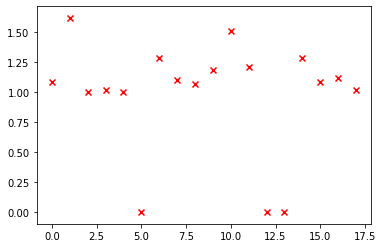

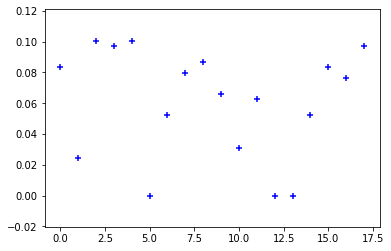

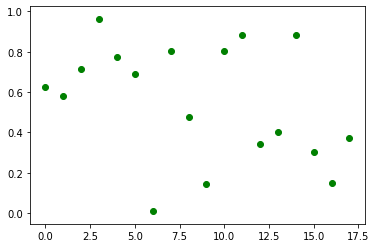

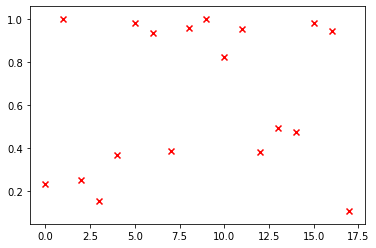

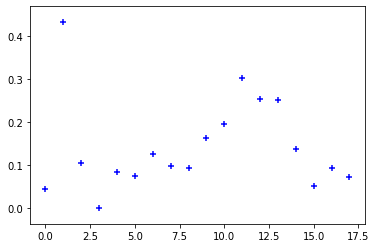

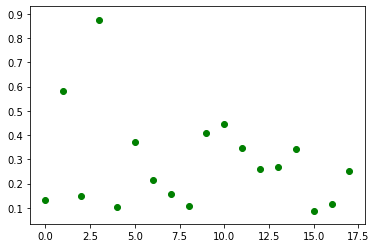

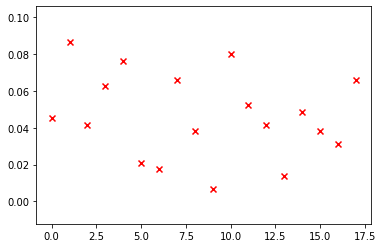

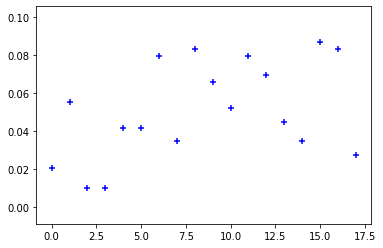

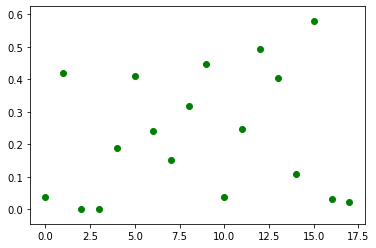

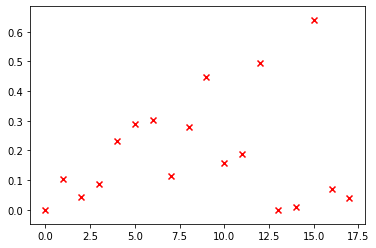

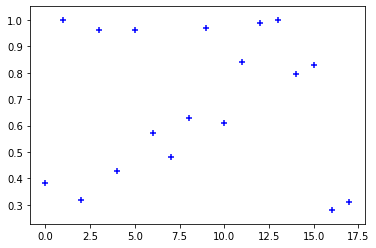

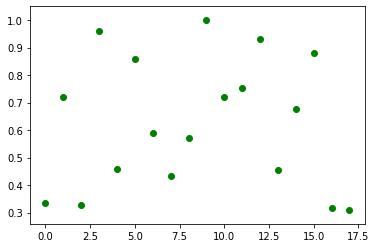

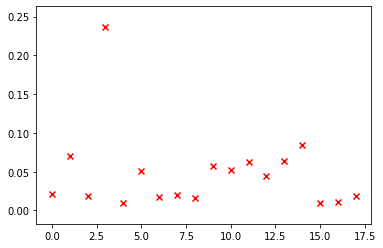

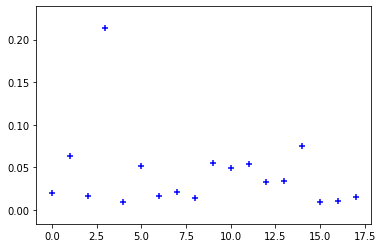

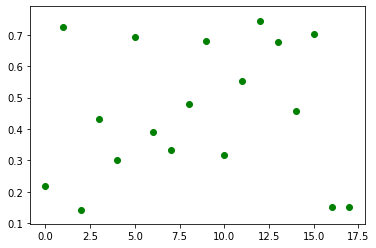

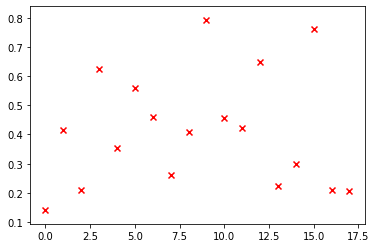

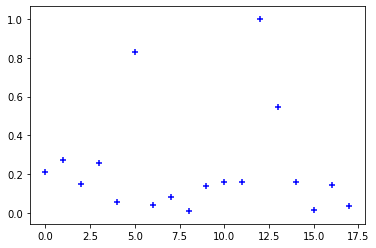

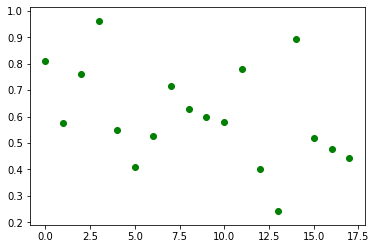

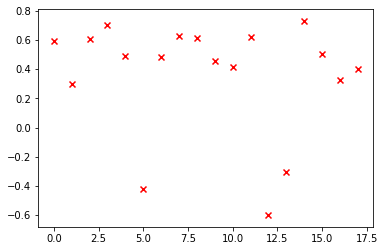

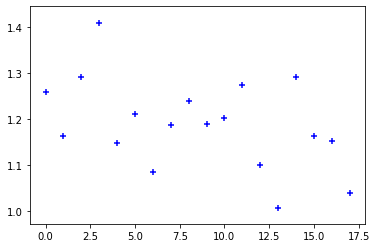

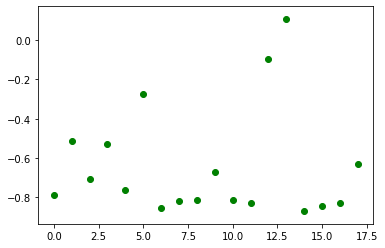

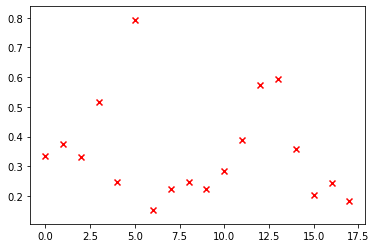

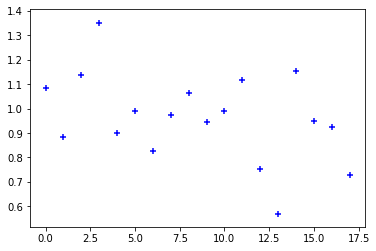

In [17]:
matrix = feature_df.values
means = np.mean(matrix, axis=0)
# print(means)
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    plt.show()
    # Save Images
#     plt.savefig('Images/Patient' + str(patient) + '/' + columns[i] + '.png')

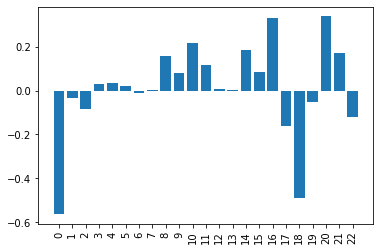

0.5855795693997896
['Slope_minmax' 'Mean_diff' 'Mean_after' 'Var_fft' 'PeakVal1_error'
 'Max_fft' 'TimeDiff_minmax' 'PeakTime1_error' 'Var2_window'
 'PeakTime2_error' 'Var1_window' 'PeakHt2_error' 'PeakVal2_error'
 'PeakHt1_error' 'Min2_window' 'Mean2_window' 'Max2_window' 'Min1_window'
 'Mean_fft' 'Mean1_window' 'Max1_window' 'Mean_before' 'Min_fft']
[-0.56384825 -0.49045001 -0.16052875 -0.12081983 -0.08230042 -0.05266212
 -0.0359133  -0.01295863  0.00077421  0.00408099  0.00551667  0.02291348
  0.02970259  0.03667623  0.07984914  0.08488694  0.11838675  0.15889873
  0.17346563  0.18638372  0.21604074  0.32992125  0.33788432]


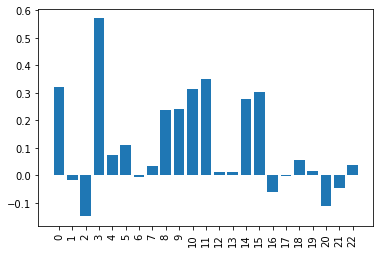

0.24897611505748377
['PeakVal1_error' 'Min_fft' 'Mean_before' 'Mean_fft' 'TimeDiff_minmax'
 'PeakTime1_error' 'Mean_after' 'Var1_window' 'Var2_window' 'Max_fft'
 'PeakTime2_error' 'Var_fft' 'Mean_diff' 'PeakHt1_error' 'PeakHt2_error'
 'Min1_window' 'Min2_window' 'Mean1_window' 'Mean2_window' 'Max1_window'
 'Slope_minmax' 'Max2_window' 'PeakVal2_error']
[-0.14778224 -0.11146007 -0.05920657 -0.04463651 -0.01569632 -0.00693969
 -0.0016258   0.0114125   0.01387001  0.01763863  0.03459041  0.03626478
  0.05758077  0.07554236  0.1119986   0.23933286  0.24180892  0.27846845
  0.30233856  0.31469609  0.32184519  0.35060009  0.57007663]


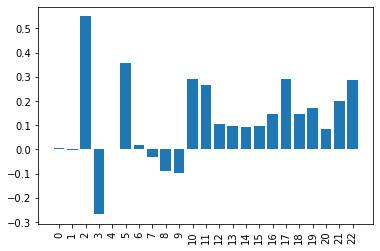

0.1789355872797288
['PeakVal2_error' 'Min2_window' 'Min1_window' 'PeakTime2_error'
 'TimeDiff_minmax' 'PeakHt1_error' 'Slope_minmax' 'PeakTime1_error'
 'Min_fft' 'Mean1_window' 'Var2_window' 'Mean2_window' 'Var1_window'
 'Mean_diff' 'Mean_before' 'Max_fft' 'Mean_fft' 'Max2_window' 'Var_fft'
 'Mean_after' 'Max1_window' 'PeakHt2_error' 'PeakVal1_error']
[-0.2677114  -0.09874001 -0.08977782 -0.03302258 -0.00207373  0.00290384
  0.00677309  0.01990933  0.08591596  0.0939502   0.0960512   0.09695931
  0.10490721  0.14479555  0.14498897  0.17279084  0.19793991  0.26665513
  0.28665607  0.28978452  0.29262952  0.35761791  0.54894084]


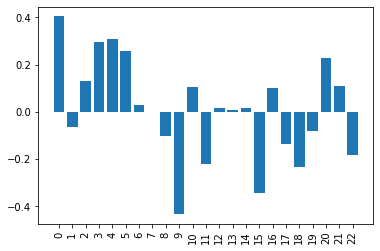

0.05992362829948837
['Min2_window' 'Mean2_window' 'Mean_diff' 'Max2_window' 'Var_fft'
 'Mean_after' 'Min1_window' 'Max_fft' 'TimeDiff_minmax' 'PeakTime2_error'
 'Var2_window' 'Var1_window' 'Mean1_window' 'PeakTime1_error'
 'Mean_before' 'Max1_window' 'Mean_fft' 'PeakVal1_error' 'Min_fft'
 'PeakHt2_error' 'PeakVal2_error' 'PeakHt1_error' 'Slope_minmax']
[-0.43498714 -0.34413761 -0.23367956 -0.22034247 -0.18550781 -0.13505038
 -0.10289519 -0.08226926 -0.06666857 -0.00316327  0.00822474  0.01638111
  0.01642957  0.02941704  0.09862917  0.10355516  0.10953625  0.13152484
  0.22813088  0.25840831  0.29401271  0.30796949  0.4042395 ]


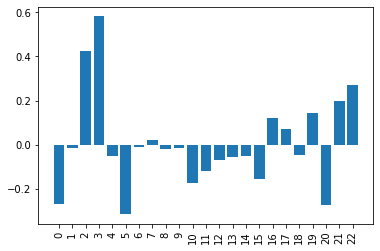

0.04889363245600683
['PeakHt2_error' 'Min_fft' 'Slope_minmax' 'Max1_window' 'Mean2_window'
 'Max2_window' 'Var1_window' 'Var2_window' 'PeakHt1_error' 'Mean1_window'
 'Mean_diff' 'Min1_window' 'Min2_window' 'TimeDiff_minmax'
 'PeakTime1_error' 'PeakTime2_error' 'Mean_after' 'Mean_before' 'Max_fft'
 'Mean_fft' 'Var_fft' 'PeakVal1_error' 'PeakVal2_error']
[-0.31467641 -0.27327553 -0.26987811 -0.17202188 -0.15481611 -0.1178841
 -0.07053839 -0.05583628 -0.05236728 -0.05177577 -0.04759085 -0.01936539
 -0.01715388 -0.01409613 -0.01199361  0.02050085  0.07127651  0.11886736
  0.14152461  0.19601726  0.26894426  0.42620004  0.58065149]


In [18]:
# PCA
pca = PCA(n_components=5)
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    plt.show()
    positives = np.array(np.argwhere(components[i] > 0).flatten())
    positive_sorted = np.argsort(components[i][:])
    positives = positive_sorted
#     print(components[i])
#     print(positives)
#     print(columns)
    print(variances[i])
    print(columns[positives])
    print(components[i][positives])
#     plt.savefig('Images/Patient' + str(patient) + '/' + 'PCA' + str(i) + '.png')
#     print(components[i])

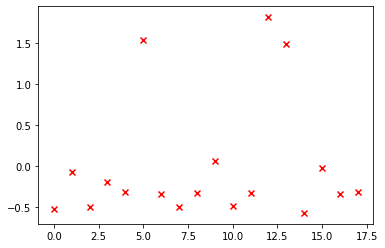

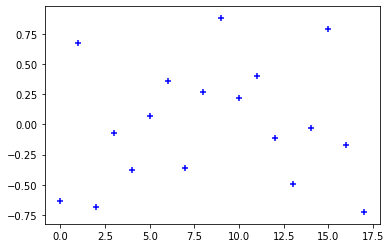

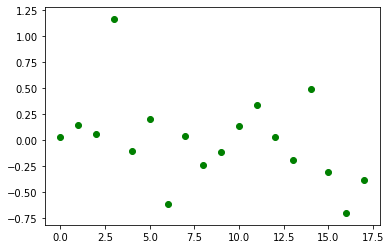

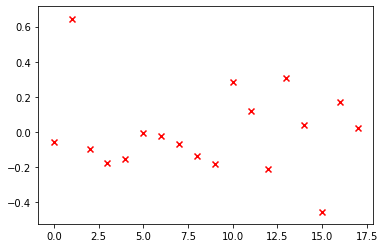

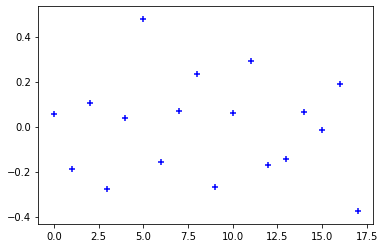

In [19]:
transformed_matrix = pca.transform(matrix)
for i in range(0, transformed_matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, transformed_matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
#     plt.show()
    plt.savefig('Images/Patient' + str(patient) + '/' + 'Transformed_' + str(i) + '.png')